## An Unsupervised Approach for Automatic Activity Recognition based on Hidden Markov Model Regression



## Exemple Gaussian HMM: one sequence

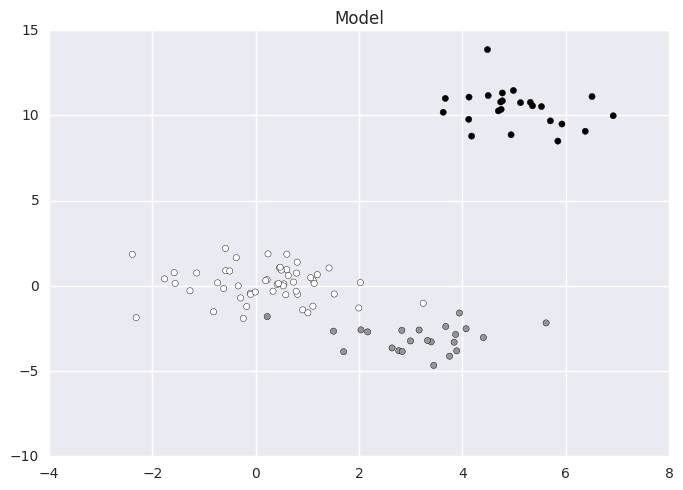

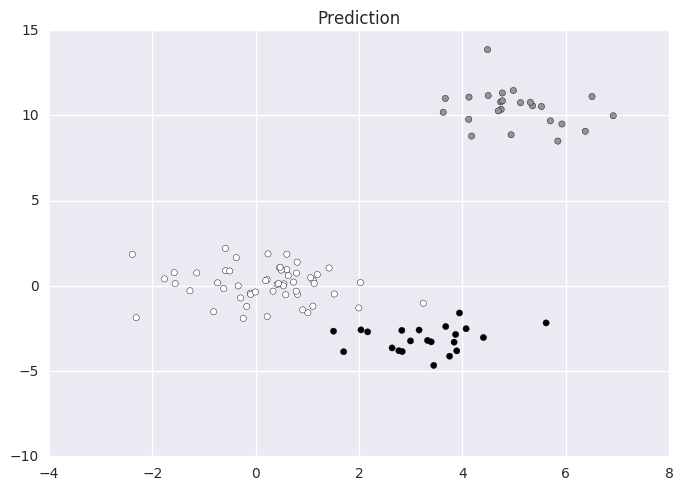

1.29168282548e-152


In [22]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
np.random.seed(42)

# Generating variables with known parameter distributions 
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(100)

plt.scatter(X[:,0],X[:,1], c=Z)
plt.title('Model')
plt.show()

# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
remodel.fit(X)  
Z2 = remodel.predict(X)
plt.scatter(X[:,0],X[:,1], c=Z2)
plt.title('Prediction')
plt.show()

print (np.exp(remodel.score(X)))

## Exemple Gaussian MHMM: multiple sequences

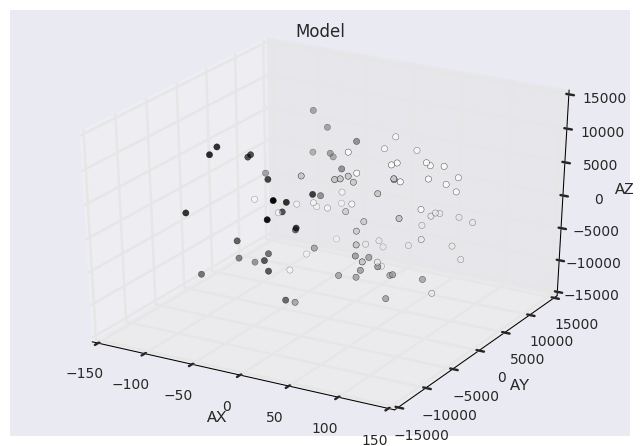

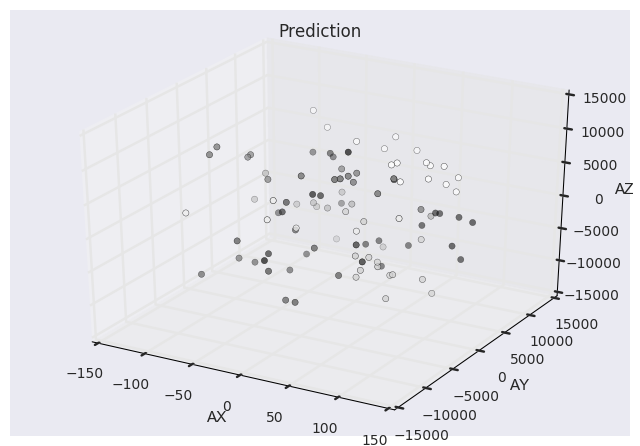

In [11]:
import numpy as np
import random
from hmmlearn import hmm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

# Generating random variables
# Time
T=[i for i in range(100)]
# Accelertaion X
X=[random.uniform(-100,100) for i in range(100)]
AX=np.array(X)

# Acceleration Y
Y=[100*random.uniform(-100,100) for i in range(100)]
AY=np.array(Y)

# Acceleration Z
Z=[100*random.uniform(-100,100) for i in range(100)]        
AZ=np.array(Z)

# Activités: 8 types
A=[0 for i in range(100)]
for i in range(100):
    if (X[i] > 0) & (Y[i] > 0) & (Z[i] > 0):
        A[i]=0
    elif (X[i] > 0) & (Y[i] > 0) & (Z[i] < 0):
        A[i]=1
    elif (X[i] > 0) & (Y[i] < 0) & (Z[i] > 0):
        A[i]=2
    elif (X[i] > 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=3
    elif (X[i] < 0) & (Y[i] > 0) & (Z[i] > 0):
        A[i]=4
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=5
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] > 0):
        A[i]=6
    elif (X[i] < 0) & (Y[i] < 0) & (Z[i] < 0):
        A[i]=7      
AA=np.array(A) 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA)
plt.title('Model')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()

# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=8, covariance_type="full", n_iter=100000)
M=[[AX[i],AY[i],AZ[i]] for i in range(100)]
AM=np.array(M)
remodel.fit(AM)  
AA2 = remodel.predict(AM)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA2)
plt.title('Prediction')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()


## Features

In [12]:
from scipy import signal
import pandas as pd
import seaborn

names = ['ind', 'ax', 'ay', 'az', 'label']
acc_names = ['ax', 'ay', 'az']
label2str = {1:'Working at Computer', 2:'Standing Up, Walking and Going up-down stairs', 
             3:'Standing', 4:'Walking',5:'Going Up\Down Stairs', 6:'Walking and Talking with Someone', 
             7:'Talking while Standing'}
df = pd.read_csv("1.csv", sep=',', names=names)
del df['ind']
df = df[df.label != 0]
df['label_str'] = df.label.apply(lambda x:label2str[x])


# Magnitude
df['mag'] = np.sqrt(np.square(df[acc_names]).sum(axis=1)) 
# Median filter - 3rd ordre
def med_fil(df, names):
    df_r = pd.DataFrame()
    df = df[names]
    for column in df.columns:
        name = column+'_mf'
        df_r[name] = signal.medfilt(df[column].values)
    return df_r
df_med = med_fil(df, acc_names)
# Diffrential
def diffrential(df, names):
    df = df[names]
    df_r = df.diff(periods=1, axis=0).fillna(method='backfill')
    df_r.columns = [names[0]+'_d', names[1]+'_d', names[2]+'_d']
    return df_r
df_diff = diffrential(df, acc_names)
# Low pass filter
def lowpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='low')
    for column in df.columns : 
        name = column+'_lp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_lp = lowpass(df, acc_names)  
# High pass filter 
def highpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='high')
    for column in df.columns : 
        name = column+'_hp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_hp = highpass(df, acc_names)

# Total
df = pd.concat([df, df_med, df_diff, df_lp, df_hp], axis=1)
df.head()
print(df)

          ax    ay    az  label               label_str          mag   ax_mf  \
0       1502  2215  2153      1     Working at Computer  3434.768988  1502.0   
1       1667  2072  2047      1     Working at Computer  3355.932359  1611.0   
2       1611  1957  1906      1     Working at Computer  3171.435952  1611.0   
3       1601  1939  1831      1     Working at Computer  3110.543843  1611.0   
4       1643  1965  1879      1     Working at Computer  3176.683018  1604.0   
5       1604  1959  1921      1     Working at Computer  3178.165823  1640.0   
6       1640  1829  1940      1     Working at Computer  3130.246156  1607.0   
7       1607  1910  1910      1     Working at Computer  3143.031817  1607.0   
8       1546  2045  1910      1     Working at Computer  3196.911165  1546.0   
9       1529  2049  1972      1     Working at Computer  3228.780884  1546.0   
10      1637  1978  1945      1     Working at Computer  3221.067835  1596.0   
11      1596  2046  1866      1     Work

## Première essai sur notre DATA: l'individu 1

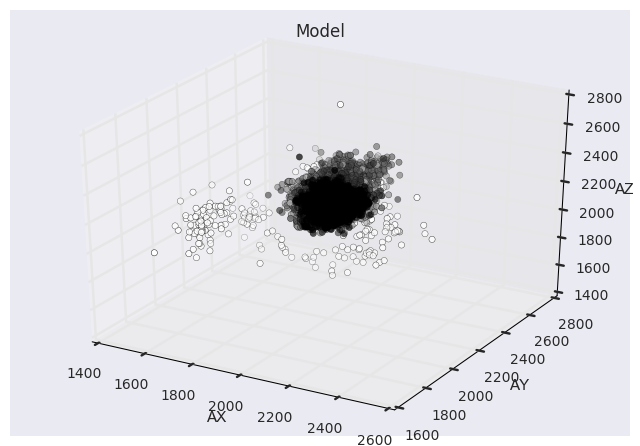

In [13]:
import numpy as np
import random
from hmmlearn import hmm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

# Uploadinf the data
DATA = np.genfromtxt('1.csv', delimiter = ',')
# Size
L=len(DATA[:,0])
# Time
T=DATA[:,0]
# Acceleration X
AX=DATA[:,1]
# Acceleration Y
AY=DATA[:,2]
# Acceleration Z
AZ=DATA[:,3]
# Acivities: 7 types
AA=DATA[:,4]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA)
plt.title('Model')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()

# Magnitude
mag=df['mag']
amag=np.array(mag)
AM=amag[:]
# AX_MF
xmf=df['ax_mf']
axmf=np.array(xmf)
AXMF=axmf[:]
# AY_MF
ymf=df['ay_mf']
aymf=np.array(ymf)
AYMF=aymf[:]
# AZ_MF
zmf=df['az_mf']
azmf=np.array(zmf)
AZMF=azmf[:]
# AX_D
xd=df['ax_d']
axd=np.array(xd)
AXD=axd[:]
# AY_D
yd=df['ay_d']
ayd=np.array(yd)
AYD=ayd[:]
# AZ_D
zd=df['az_d']
azd=np.array(zd)
AZD=azd[:]
# AX_LP
xlp=df['ax_lp']
axlp=np.array(xlp)
AXLP=axlp[:]
# AY_LP
ylp=df['ay_lp']
aylp=np.array(ylp)
AYLP=aylp[:]
# AZ_LP
zlp=df['az_lp']
azlp=np.array(zlp)
AZLP=azlp[:]
# AX_HP
xhp=df['ax_hp']
axhp=np.array(xhp)
AXHP=axhp[:]
# AY_HP
yhp=df['ay_hp']
ayhp=np.array(yhp)
AYHP=ayhp[:]
# AZ_HP
zhp=df['az_hp']
azhp=np.array(zhp)
AZHP=azhp[:]

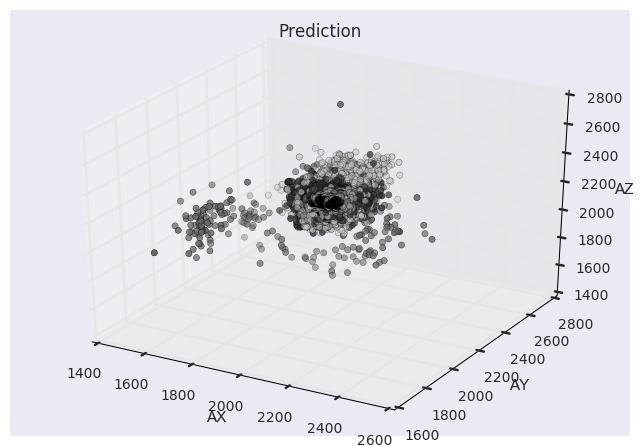

In [28]:
# Learning parametres using the dataset
remodel = hmm.GaussianHMM(n_components=7, covariance_type="full", n_iter=100000)
M=[[AX[i],AY[i],AZ[i],AM[i],AXMF[i],AYMF[i],AZMF[i],AXD[i],AYD[i],AZD[i],AXLP[i],AYLP[i],AZLP[i],AXHP[i],AYHP[i],AZHP[i]] for i in range(L)]
LM=np.array(M)
remodel.fit(LM)  
AA2 = remodel.predict(LM)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(AX, AY, AZ,c=AA2)
plt.title('Prediction')
ax.set_xlabel('AX')
ax.set_ylabel('AY')
ax.set_zlabel('AZ')
plt.show()

In [32]:
# Scores and predictor accuracy
Sc=0
for a in range(7):
    Pr=[0 for i in range(7)]
    print ('Activité ',a+1)
    for i in range(L):
        if AA[i]==a+1:
            Pr[AA2[i]]=Pr[AA2[i]]+1
    print(Pr)
    Sc=Sc+max(Pr)
    
print('Score')
print(Sc/L)

Activité  1
[0, 30601, 76, 1974, 307, 540, 179]
Activité  2
[0, 0, 94, 388, 0, 252, 194]
Activité  3
[5414, 0, 256, 972, 0, 385, 4152]
Activité  4
[344, 0, 7524, 9684, 0, 9304, 4]
Activité  5
[100, 0, 565, 757, 0, 1710, 59]
Activité  6
[243, 0, 706, 886, 0, 944, 138]
Activité  7
[51093, 2073, 797, 8351, 0, 1060, 20374]
Score
0.6143630769230769
